# CONFIGURING

In [116]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import json
import time
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import NaN
from sklearn.utils import shuffle
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

# CLEANING AND ENGINEERING

In [117]:
def cleaning_engineering(df) :
    #DROP NAN AND USELESS VALUES
    df = df.replace(-1, NaN)
    df.dropna(subset='price', inplace = True)
    df.dropna(subset='number_of_bedrooms', inplace = True)
    df.dropna(subset='surface', inplace = True)
    df.drop(df.index[df['type_of_sale'] != 'residential_sale'], inplace=True)
    df.drop(df.index[df['subtype_of_property'] == 'APARTMENT_BLOCK'], inplace=True)
    df.drop(df.index[df['type_of_property'] == 'HOUSE_GROUP'], inplace=True)
    df.drop(df.index[df['type_of_property'] == 'APARTMENT_GROUP'], inplace=True)

    #REPLACE NAN BY 0
    df["swimming_pool"] = df["swimming_pool"].replace(NaN, 0).astype(int)
    df["garden"] = df["garden"].replace(NaN, 0).astype(int)
    df["terrace"] = df["terrace"].replace(NaN, 0).astype(int)
    
    #TRANSLATE CATEGORIES IN NUM VALUES

        #Property_type
    map_property = {"HOUSE":1, "APARTMENT":0}
    df["type_of_property"] = df["type_of_property"].map(map_property).astype(int)

        #State_of_building
    map_state = {"GOOD":1, "TO_RENOVATE":0, "AS_NEW":1, "JUST_RENOVATED":1, "TO_RESTORE":0, "NO_INFO":1, "TO_BE_DONE_UP":1}
    df["state_of_the_building"] = df["state_of_the_building"].map(map_state).astype(int)

        #Postal code and communes
    def create_zip_score(df_merge):
        #import and merge zipcode to dataset
        column_names_zip = ['country_code','postal_code','municipality','region','region_code','province', 'province_code','arrondissement', 'nbr_mun', 'longitude', 'latitude','other']
        zip_code = pd.read_csv('be_zipcode.txt', sep="\t", header=None , names=column_names_zip).drop_duplicates(['postal_code','region','arrondissement','province'])
        arr_zip_code = zip_code[['postal_code','arrondissement','region', 'province']]
        df_merge = df_merge.merge(arr_zip_code,how='outer', on='postal_code' )

        #count the number of sales per postal code en arrondissement
        mapping_1 = df_merge.groupby('postal_code').count()['arrondissement']
        mapping_2 = df_merge.groupby('arrondissement').count()['region_y']
        df_merge['obs_per_postc'] = df_merge.postal_code.replace(mapping_1)
        df_merge['obs_per_arr'] = df_merge.arrondissement.replace(mapping_2)

        # Creation of a dataset with zip score
        zip_code_score = df_merge.groupby(['arrondissement','postal_code']).agg({'price': 'median', 'obs_per_postc': 'mean', 'obs_per_arr': 'mean'}).reset_index().rename(columns={'price':'median_p_zip'})
        mapping_3 = df_merge.groupby(['arrondissement']).median()['price']
        zip_code_score['median_p_arr'] = zip_code_score.arrondissement.replace(mapping_3)
        #print 
        zip_code_score.loc[zip_code_score['obs_per_postc'] > min(zip_code_score['obs_per_arr']), 'postal_code_score'] = zip_code_score['median_p_zip']
        zip_code_score.loc[zip_code_score['postal_code_score'].isna(),'postal_code_score'] = zip_code_score['median_p_arr']
        zip_code_score = zip_code_score[['postal_code','postal_code_score']].sort_values('postal_code_score')
        return zip_code_score

    df_cp = create_zip_score(df)
    df = df.merge(df_cp, how='outer', on='postal_code')


    #DROP FEATURES
    del df["province"]
    del df["type_of_sale"]
    del df["Unnamed: 0"]
    del df["id"]
    del df["postal_code"]
    del df["locality"]
    del df["fully_equipped_kitchen"]
    del df["kitchen_type"]
    del df["land_surface"]
    del df["number_of_facades"]
    del df["garden_surface"]
    del df["terrace_surface"]
    del df["furnished"]
    del df["open_fire"]
    del df["region"]
    del df["subtype_of_property"]


    #DROP OUTLIERS
    factor = 2

        #Price
    upper_lim = df['price'].mean() + df['price'].std() * factor
    df = df[(df['price'] < upper_lim) & (df['price'] >= 20000)]

        #Surface
    upper_lim1 = df['surface'].mean() + df['surface'].std() * factor
    lower_lim1 = df['surface'].mean() - df['surface'].std() * factor
    df = df[(df['surface'] < upper_lim1) & (df['surface'] > lower_lim1)]

        #Bedrooms
    upper_lim2 = df['number_of_bedrooms'].mean() + df['number_of_bedrooms'].std() * factor
    lower_lim2 = df['number_of_bedrooms'].mean() - df['number_of_bedrooms'].std() * factor
    df = df[(df['number_of_bedrooms'] < upper_lim2) & (df['number_of_bedrooms'] > lower_lim2)]


    #STANDARDIZATION
    df['number_of_bedrooms'] = (df['number_of_bedrooms'] - df['number_of_bedrooms'].mean()) / df['number_of_bedrooms'].std()
    df['surface'] = (df['surface'] - df['surface'].mean()) / df['surface'].std()
    df['postal_code_score'] = (df['postal_code_score'] - df['postal_code_score'].mean()) / df['postal_code_score'].std()
    
    return df


# REGRESSION TRAINING

In [118]:
#SELECT THE FILE
df_train = pd.read_csv("df_train.csv")
df_train = cleaning_engineering(df_train)

# Define the ML model variable
X_train = df_train.drop('price',axis= 1)
y_train = df_train['price']

#Create a linear regression model
regressor = LinearRegression()

#Fit the model with training data
regressor.fit(X_train,y_train)

#Display the score
regressor.score(X_train, y_train)

/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_34733/3403402385.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mapping_3 = df_merge.groupby(['arrondissement']).median()['price']


0.5816898856449167

In [119]:
#Create linear regression



x_weighted = df_train

# TEST THE MODEL

In [120]:
#SELECT THE FILE
df_test = pd.read_csv("df_test.csv")
df_test = cleaning_engineering(df_test)

# Define the ML model variable
X_test = df_test.drop('price',axis= 1)
y_test = df_test['price']

y_pred= regressor.predict(X_test)

# regressor.score(X_test, y_test)

/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_34733/3403402385.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mapping_3 = df_merge.groupby(['arrondissement']).median()['price']


In [121]:
print(X_test.columns)
regressor.coef_

Index(['type_of_property', 'number_of_bedrooms', 'surface', 'terrace',
       'garden', 'swimming_pool', 'state_of_the_building',
       'postal_code_score'],
      dtype='object')


array([-48263.03864636,  23079.38545786, 113950.9246723 ,  28109.60283051,
        10064.18501535, 131032.34189887,  83829.32294059,  85887.21619118])

In [128]:
pred_df=pd.DataFrame({'actual_price':y_test,'predicted_price':y_pred,'Difference':abs((y_test-y_pred)/y_test)*100,'surface': X_test['surface']})
pred_df.to_csv("pred_df.csv",index = False)
#pour trouver ou sont les pbs --> par prix ou par quartier, etc...

<AxesSubplot: xlabel='actual_price', ylabel='predicted_price'>

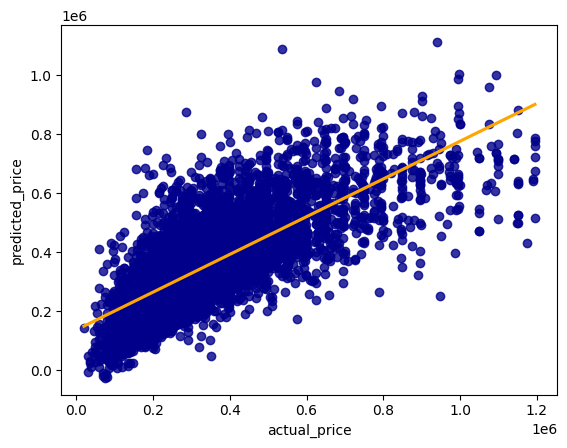

In [129]:
sb.regplot(data=pred_df, x="actual_price", y="predicted_price", ci=None, color ='darkblue', line_kws={"color": "orange"})

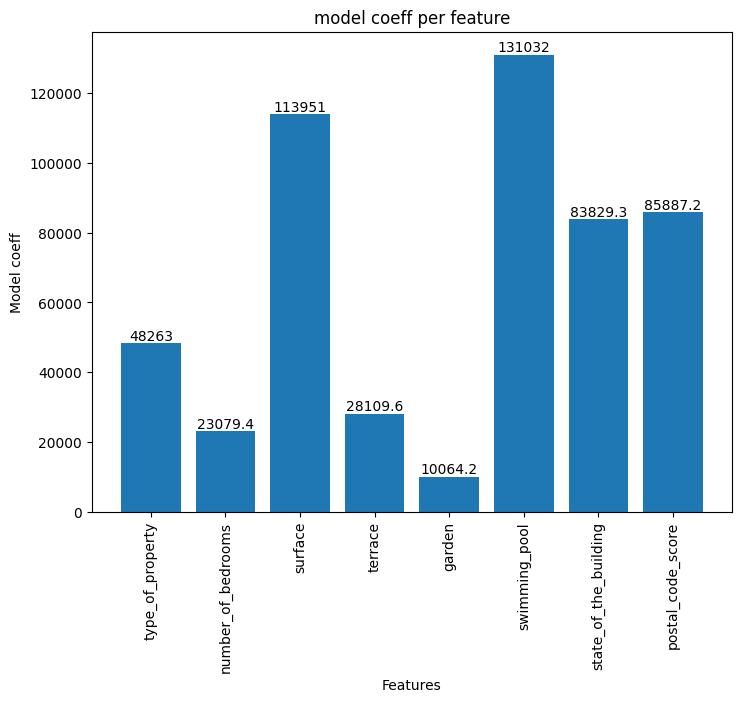

In [130]:
# print(list(abs(regressor.coef_)))
# print(list(X_test.columns))


# df_graph = pd.DataFrame(list(abs(regressor.coef_)))
# df_graph.columns=list(X_test.columns)
# df_graph.head()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Features = X_test.columns
Predict_error = abs(regressor.coef_)
bars = ax.bar(Features, Predict_error)
ax.bar_label(bars)
plt.xlabel('Features')
plt.ylabel('Model coeff')
plt.title("model coeff per feature")
plt.xticks(rotation=90)
plt.show()


<AxesSubplot: xlabel='actual_price', ylabel='Difference'>

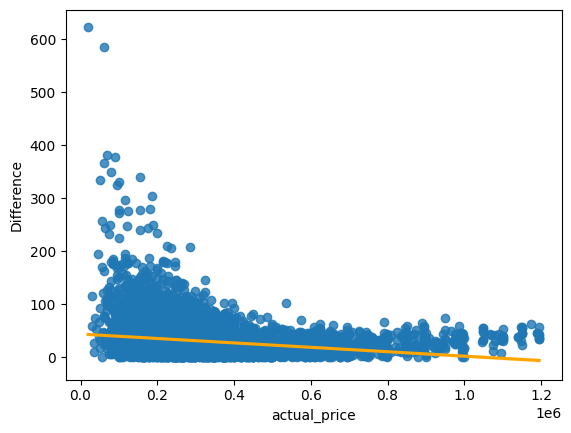

In [131]:
sb.regplot(pred_df, x='actual_price', y='Difference', line_kws={"color": "orange"})

<AxesSubplot: xlabel='surface', ylabel='Difference'>

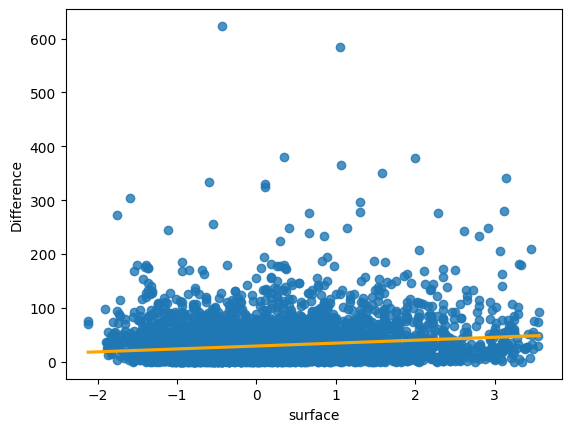

In [133]:
sb.regplot(pred_df, x='surface', y='Difference', line_kws={'color': 'orange'})